# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Deep Learning
---

create by Arwin Yu

## Tutorial 06 - Generative Adversarial Networks - GAN
---
<center><img src="./assets/gan1.png" style="height:300px"></center>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* Generative Adversarial Networks
    * 对抗机制
    * 损失函数
    * 训练策略
    * 手写数字示例
* Improved GAN 
    * 特征匹配
    * 小批量判别器
    * 单侧标签平滑
    * 虚拟批规范化
* f-GAN
    * 损失推导
    * 损失与散度框架
* W-GAN
    * 梯度弥散
    * Wasserstein 距离
    * Wasserstein 损失

## <img src="https://img.icons8.com/cute-clipart/64/000000/alarm.png" style="height:50px;display:inline"> The Adversarial Mechanism
---
生成对抗网络（GAN）是深度学习领域的一个革命性概念，为数据生成提供了一种全新的方式。其名称中的**对抗**体现了核心思想：通过两个神经网络之间的相互竞争来生成数据。

这两个网络分别是：生成器 (Generator) 和判别器 (Discriminator)。

想象一个例子，生成对抗网络如同一场精心编排的艺术表演。舞台上有两位主要的艺术家：生成器和判别器。

* 生成器充满创意和魔法，从无中创造，挥动画笔，尝试制作最美的画作。它从一个随机的灵感（噪声向量）出发，试图创作令人信服的作品。

* 而在舞台的另一侧，判别器则扮演着批评家的角色，目光锐利，不放过任何瑕疵。当它面前展示的作品来源于真实世界时，它欣然点头；但当作品出自生成器之手，它便细细审查，决定这是真品还是赝品。这个判别过程不断地反馈给生成器，告诉它在哪里做得不够好，需要改进。

* 这场舞蹈是一个持续的迭代过程，双方互相挑战，共同成长。

* 随着时间的流逝，生成器的技巧变得越来越纯熟，而判别器的鉴赏能力也日益提高。最终，我们希望在这场舞蹈中，生成器能够创作出如此高质量的作品，以至于即使是最尖锐的批评家——判别器，也无法区分其真伪。
---

具体来说：

在生成对抗网络的舞台上，生成器扮演着一个充满创意的艺术家角色。这位“艺术家”从一个随机向量中汲取灵感，通过一系列神经网络层（如卷积或全连接层）将其转化为有形的作品。与真实世界的艺术家（真实的数据）不断练习和修正技巧以完善作品的过程相似，生成器也不断地调整自己的参数，以使其产生的作品更加逼真。其目标是创作出令人信服的数据，以至于判别器——这位严格的艺术评论家，难以区分其真伪。因此，**生成器不仅是一个创作者，更是一个终身学习者，不断地通过判别器的反馈来完善自己的“艺术技巧”**。

而判别器是那位批判眼光犀利的艺术评论家。它对每一件作品都进行严格的审查，通过其内部由多个神经网络层（例如卷积层或全连接层）组成的复杂机制，判定这件作品是否为真实世界的佳作，还是生成器所创作的模仿品。判别器在接收到数据后，通过其网络结构输出一个评分，表示这份数据的真实性概率。其核心任务是正确地识别出真实数据和生成数据，并通过其判断为生成器提供宝贵的反馈，使其有机会更进一步地完善自己的创作技能。因此，**判别器既是一个严苛的评审，也是生成器成长道路上的关键引导者**。


<center><img src="./assets/gan2.png" style="height:300px"></center>

当谈论传统的 GAN 时, 它的目标函数是一个两人零和博弈, 其中生成器 ( $G$ ) 和判别器 ( $D$ ) 有对立的目标。博弈过程可以表示为:
$$
\min _G \max _D \mathcal{L}(D, G)=\mathrm{E}_{x \sim p_{\text {dat }}(x)}[\log D(x)]+\mathrm{E}_{z \sim p_z(z)}[\log (1-D(G(z)))]
$$

* 外部的最小化 (min) 代表生成器 $G$ 的目标。生成器希望最小化判别器对其生成的样本产生的正确分类概率。换句话说, 生成器试图骗过判别器, 让其认为生成的样本是真实的。
* 内部的最大化 (max)代表判别器 $D$ 的目标。判别器希望最大化其对真实和生成样本的分类能力。

生成对抗网络的核心思想是在生成器（Generator）和判别器（Discriminator）之间建立一个竞争关系。为了使这种竞争有效，需要为这两个网络定义适当的损失函数。在最基本的GAN中，生成器的任务是生成能够欺骗判别器的数据。具体来说，生成器希望判别器认为其生成的数据尽可能地接近真实数据。因此，生成器的损失函数通常基于判别器对生成数据的评估。

In [1]:

import torch as t
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10, MNIST
from pylab import plt
%matplotlib inline

class Config:
    lr = 0.0002
    nz = 100 # noise dimension
    image_size = 64
    image_size2 = 64
    nc = 1 # chanel of img 
    ngf = 64 # generate channel
    ndf = 64 # discriminative channel
    beta1 = 0.5
    batch_size = 32
    max_epoch = 10 # =1 when debug
    workers = 2
    gpu = True # use gpu or not
    
opt=Config()

# data preprocess
transform=transforms.Compose([
                transforms.Resize(opt.image_size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
                ])

dataset=MNIST(root='data', transform=transform, download=True)
# dataloader with multiprocessing
dataloader=t.utils.data.DataLoader(dataset,
                                   opt.batch_size,
                                   shuffle=True,
                                   num_workers=opt.workers)
# define model
netg = nn.Sequential(
    nn.ConvTranspose2d(opt.nz,opt.ngf*8,4,1,0,bias=False),
    nn.BatchNorm2d(opt.ngf*8),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*8,opt.ngf*4,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ngf*4),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*4,opt.ngf*2,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ngf*2),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf*2,opt.ngf,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ngf),
    nn.ReLU(True),

    nn.ConvTranspose2d(opt.ngf,opt.nc,4,2,1,bias=False),
    nn.Tanh()
)

netd = nn.Sequential(
    nn.Conv2d(opt.nc,opt.ndf,4,2,1,bias=False),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf,opt.ndf*2,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*2),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf*2,opt.ndf*4,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*4),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf*4,opt.ndf*8,4,2,1,bias=False),
    nn.BatchNorm2d(opt.ndf*8),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(opt.ndf*8,1,4,1,0,bias=False),
    nn.Sigmoid()
)

## <img src="https://img.icons8.com/?size=100&id=bJclkWKA0ENc&format=png&color=000000" style="height:50px;display:inline">GAN模型与损失详解
---
假设 $G$ 是生成器, $D$ 是判别器。当给定一个随机噪声向量 $z$ 时, 生成器 $G$ 生成一个数据 $G(z)$ 。

判别器 $D$ 评估这个数据并给出一个概率 $D(G(z))$, 表示它认为 $G(z)$ 是真实数据的概率。

生成器希望 $D(G(z))$ 尽可能地接近 1, 即判别器被欺骗并认为生成数据是真实的。

**单独考虑生成器：**

如果只考虑从生成器产生的图片, 而忽略真实数据的影响 $\left(\mathrm{E}_{x \sim p_{d: 18}(x)}[\log D(x)]=0\right)$, 原始的GAN损失可以简写为:
$$
L_G=\mathrm{E}_{z \sim p_z(z)}[\log (1-D(G(z)))]
$$

公式解释: 

* 当 $D(G(z))$ 接近 1 时, 意味着判别器几乎完全确信生成的数据是真实的。此时, $1-D(G(z))$ 接近 0 , 而 $\log (1-D(G(z)))$ 的值会是一个很大的负数。这正是我们所期望的最小化生成器损失。
* 当 $D(G(z))$ 接近 0 时, 意味着判别器认为生成的数据是假的。在这种情况下, $1-D(G(z))$ 接近 1, 因此 $\log (1-D(G(z)))$ 接近 0 。生成器会尽量避免这种情况, 因为生成器的目标是最小化 $\log (1-D(G(z)))$, 这实际上是鼓励生成器产生能够欺骗判别器的数据。

**为什么损失公式中会存在一个log？**

一方面，GAN中涉及到的损失函数常常与概率有关，这些概率因为层级结构的原因经常需要进行乘法操作。当处理很小的概率值时，它们的乘积可能会变得非常小，接近于机器的数值下限，这可能导致数值不稳定，即所谓的“下溢”问题。下溢会导致这些非常小的值被四舍五入为零。通过采用对数，可以将乘法操作转化为加法操作，这有助于提高数值稳定性。

另一方面，log有放大罚分的效应。具体来说, 当 $D(G(z)$ )很小 (表示判别器几乎确定生成的样本是假的) 时, $1-D(G(z))$ 仍然接近 1。此时, $\log (1-D(G(z)))$ 的值接近于 0 。然而, 随着 $D(G(z))$ 的增加, 即生成的样本开始获得某种程度的逼真度, 但仍然可以被判别器区分出来, $1-D(G(z))$ 开始迅速减小。对数函数对这些值的放大效应明显。例如, $\log (1-0.5)=-0.693$ 和 $\log (1-0.9)=-2.302$, 可以看到, 当由生成器生成的样本从被判别器评估为 $50 \%$ 真实到 $90 \%$ 真实时, 损失值有了显著的下降。这种放大效应确保了，当生成器稍微提高其生成样本的逼真度时，它会受到一个大的罚分，鼓励它更进一步地改进。这种放大罚分效应确保生成器不满足于仅仅产生稍好的样本；相反，它被激励要产生尽可能逼真的样本，以降低其损失。

**单独考虑判别器：**

如果只考虑判别器的角度，GAN的损失函数主要关注于判别器如何区分真实数据和生成的数据。对于判别器 $D$, 损失函数为:
$$
L_D=\mathrm{E}_{x \sim p_{\text {data }}(x)}[\log D(x)]+\mathrm{E}_{z \sim p_z(z)}[\log (1-D(G(z)))]
$$

损失函数由两部分组成:

(1) $\mathrm{E}_{x \sim p_{\text {data}}(x)}[\log D(x)]$ : 这部分是关于真实数据的。判别器 $D$ 试图最大化对真实数据样本 $x$ 的正确分类概率。换句话说, 它希望对于来自真实数据分布的样本 $x$, 输出尽可能接近 1 。

(2) $\mathrm{E}_{z \sim p_(z)}[\log (1-D(G(z)))]$ : 这部分是关于生成的数据的。判别器 $D$ 试图最大化其对生成数据的正确分类概率, 即将其分类为假的。这意味着, 对于从先验噪声分布 $p_z$ 中采样然后通过生成器 $G$ 生成的假样本, 判别器的输出应该尽可能接近 0 。

判别器 $D$ 的**目标是最大化损失函数**。这意味着, 为了达到最佳效果, 判别器希望能够准确地区分真实数据和生成的数据。在最理想的情况下, 对于真实数据, $D(x)=1$; 而对于生成的数据， $D(G(x))=0$。

但在实际训练中，这种理想情况很少达到，因为生成器也在尝试改进自己，生成更逼真的样本来欺骗判别器。

In [2]:
# optimizer
optimizerD = Adam(netd.parameters(),lr=opt.lr,betas=(opt.beta1,0.999))
optimizerG = Adam(netg.parameters(),lr=opt.lr,betas=(opt.beta1,0.999))

# criterion
criterion = nn.BCELoss()

fix_noise = Variable(t.FloatTensor(opt.batch_size,opt.nz,1,1).normal_(0,1))
if opt.gpu:
    fix_noise = fix_noise.cuda()
    netd.cuda()
    netg.cuda()
    criterion.cuda()  

### GAN模型的训练
---

GAN 模型在开始训练之前, 首先需要选择一个合适的神经网络结构。例如, 对于图像生成, 一般基于卷积的结构偏多。初始化生成器 $G$ 和判别器 $D$ 的权重, 通常使用小的随机值。 GAN 包括两个网络: 生成器和判别器, 它们需要交替或同时训练。GAN 的循环训练大致如下:

* 首先训练判别器，使用当前的生成器生成假数据和真实数据训练判别器，判别器的目标是正确地区分真实数据和假数据。

具体来说，一方面从真实数据分布中抽取一个批量的数据 $x$, 计算判别器 $D$ 在真实数据上的输出 $D(x)$, 计算损失 $\mathrm{E}_{x \sim p_{\text {deta }}(x)}[\log D(x)]$ 。另一方面从随机噪声分布中抽取一个批量的噪声 $z$ 。使用生成器 $G$ 生成一个批量的假数据 $G(z)$ 。计算判别器 $D$ 在假数据上的输出 $D(G(z))$, 计算损失 $\mathrm{E}_{z \sim p_z(z)}[\log (1-D(G(z)))]$ 。合并真实数据和生成数据的损失，使用这个总损失来更新判别器 $D$ 的权重，通常使用优化器如Adam或RMSProp。

* 然后训练生成器，试图欺骗判别器，使其认为生成的数据是真实的，生成器的目标是生成能够被判别器误判为真实数据的数据。

具体来说，从随机噪声分布中再次抽取一个批量的噪声 $Z$, 通过判别器 $D$ 评估生成器 $G$ 产生的假数据, 计算损失 $\mathrm{E}_{z \sim p_z(z)}[\log (1-D(G(z)))]$,使用该损失更新生成器 $G$ 的权重。

每隔几个轮次，可以使用一些指标来评估生成器的输出。重复上述训练步骤直到满足终止条件，这可以是预定的训练轮数、模型性能达到某个阈值或其它条件。如果未满足条件，返回并开始新的训练循环。

在循环训练过程中，生成器和判别器都会逐渐改进，争取更好地执行其任务。最终的目标是找到一个平衡点，生成器生成的数据与真实数据几乎无法区分。**这种逐步的、反复的训练方法允许模型从数据中学习和适应，这是许多机器学习算法成功的关键。**

<center><img src="./assets/gan2.png" style="height:300px"></center>

Iteration 0/0: Discriminator Loss: 1.4153, Generator Loss: 2.2284, D(x): 0.5435, D(G(z)) (on fake data): 0.1137, D(G(z)) (on real data): 0.5437
Iteration 500/0: Discriminator Loss: 0.1514, Generator Loss: 3.0821, D(x): 0.9358, D(G(z)) (on fake data): 0.0631, D(G(z)) (on real data): 0.0774
Iteration 1000/0: Discriminator Loss: 0.4804, Generator Loss: 3.4960, D(x): 0.9392, D(G(z)) (on fake data): 0.0401, D(G(z)) (on real data): 0.3090
Iteration 1500/0: Discriminator Loss: 0.5928, Generator Loss: 0.9506, D(x): 0.6448, D(G(z)) (on fake data): 0.4395, D(G(z)) (on real data): 0.0816


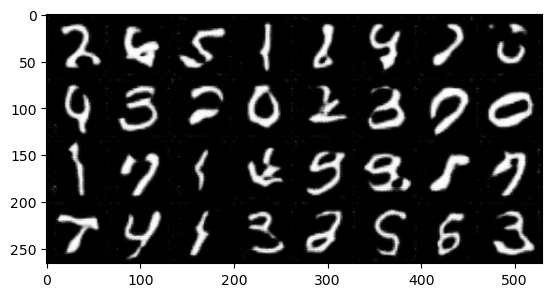

Iteration 0/1: Discriminator Loss: 0.0247, Generator Loss: 5.7162, D(x): 0.9912, D(G(z)) (on fake data): 0.0073, D(G(z)) (on real data): 0.0153
Iteration 500/1: Discriminator Loss: 1.0094, Generator Loss: 0.9566, D(x): 0.4293, D(G(z)) (on fake data): 0.5299, D(G(z)) (on real data): 0.0001
Iteration 1000/1: Discriminator Loss: 0.6532, Generator Loss: 1.8176, D(x): 0.6847, D(G(z)) (on fake data): 0.2071, D(G(z)) (on real data): 0.1556
Iteration 1500/1: Discriminator Loss: 0.1293, Generator Loss: 3.3530, D(x): 0.9577, D(G(z)) (on fake data): 0.0606, D(G(z)) (on real data): 0.0757
Iteration 0/2: Discriminator Loss: 0.3889, Generator Loss: 3.1383, D(x): 0.7578, D(G(z)) (on fake data): 0.0593, D(G(z)) (on real data): 0.0695
Iteration 500/2: Discriminator Loss: 0.0038, Generator Loss: 7.2360, D(x): 0.9991, D(G(z)) (on fake data): 0.0008, D(G(z)) (on real data): 0.0029
Iteration 1000/2: Discriminator Loss: 0.0003, Generator Loss: 8.2740, D(x): 1.0000, D(G(z)) (on fake data): 0.0003, D(G(z)) (o

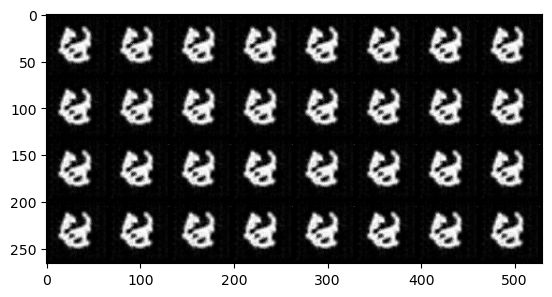

Iteration 0/3: Discriminator Loss: 45.9291, Generator Loss: 57.0330, D(x): 0.0000, D(G(z)) (on fake data): 0.0000, D(G(z)) (on real data): 0.0000
Iteration 500/3: Discriminator Loss: 46.7132, Generator Loss: 57.0013, D(x): 0.0000, D(G(z)) (on fake data): 0.0000, D(G(z)) (on real data): 0.0000
Iteration 1000/3: Discriminator Loss: 45.3573, Generator Loss: 56.9371, D(x): 0.0000, D(G(z)) (on fake data): 0.0000, D(G(z)) (on real data): 0.0000
Iteration 1500/3: Discriminator Loss: 45.8882, Generator Loss: 56.7955, D(x): 0.0000, D(G(z)) (on fake data): 0.0000, D(G(z)) (on real data): 0.0000
Iteration 0/4: Discriminator Loss: 45.8601, Generator Loss: 56.6574, D(x): 0.0000, D(G(z)) (on fake data): 0.0000, D(G(z)) (on real data): 0.0000
Iteration 500/4: Discriminator Loss: 44.3233, Generator Loss: 56.2416, D(x): 0.0000, D(G(z)) (on fake data): 0.0000, D(G(z)) (on real data): 0.0000
Iteration 1000/4: Discriminator Loss: 1.1467, Generator Loss: 6.4441, D(x): 0.9674, D(G(z)) (on fake data): 0.0028

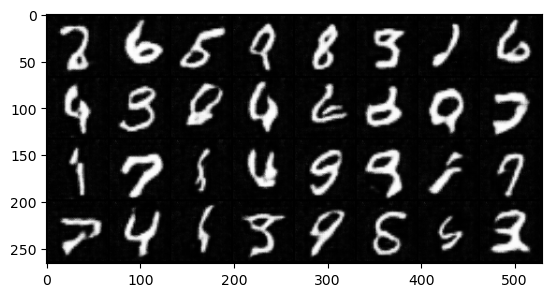

Iteration 0/5: Discriminator Loss: 0.2203, Generator Loss: 4.7817, D(x): 0.9162, D(G(z)) (on fake data): 0.0125, D(G(z)) (on real data): 0.1106
Iteration 500/5: Discriminator Loss: 0.0109, Generator Loss: 6.2570, D(x): 0.9943, D(G(z)) (on fake data): 0.0037, D(G(z)) (on real data): 0.0051
Iteration 1000/5: Discriminator Loss: 0.6208, Generator Loss: 1.0894, D(x): 0.6850, D(G(z)) (on fake data): 0.4199, D(G(z)) (on real data): 0.1146
Iteration 1500/5: Discriminator Loss: 0.0145, Generator Loss: 7.2275, D(x): 0.9875, D(G(z)) (on fake data): 0.0015, D(G(z)) (on real data): 0.0017
Iteration 0/6: Discriminator Loss: 0.1797, Generator Loss: 3.4921, D(x): 0.8830, D(G(z)) (on fake data): 0.0603, D(G(z)) (on real data): 0.0432
Iteration 500/6: Discriminator Loss: 0.0832, Generator Loss: 4.9905, D(x): 0.9758, D(G(z)) (on fake data): 0.0134, D(G(z)) (on real data): 0.0556
Iteration 1000/6: Discriminator Loss: 0.0076, Generator Loss: 5.4778, D(x): 0.9961, D(G(z)) (on fake data): 0.0072, D(G(z)) (o

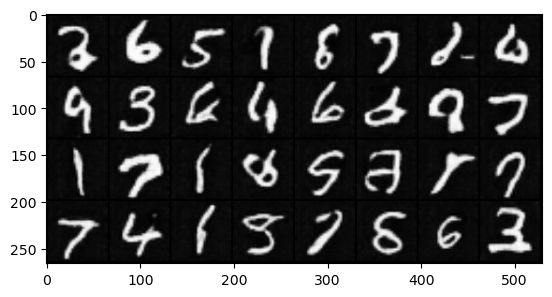

Iteration 0/7: Discriminator Loss: 0.3365, Generator Loss: 5.0217, D(x): 0.9900, D(G(z)) (on fake data): 0.0175, D(G(z)) (on real data): 0.2437
Iteration 500/7: Discriminator Loss: 0.0115, Generator Loss: 5.7578, D(x): 0.9984, D(G(z)) (on fake data): 0.0054, D(G(z)) (on real data): 0.0098
Iteration 1000/7: Discriminator Loss: 0.0230, Generator Loss: 7.0461, D(x): 0.9833, D(G(z)) (on fake data): 0.0015, D(G(z)) (on real data): 0.0059
Iteration 1500/7: Discriminator Loss: 0.2590, Generator Loss: 3.4847, D(x): 0.8923, D(G(z)) (on fake data): 0.0504, D(G(z)) (on real data): 0.1185
Iteration 0/8: Discriminator Loss: 0.0319, Generator Loss: 5.4885, D(x): 0.9725, D(G(z)) (on fake data): 0.0072, D(G(z)) (on real data): 0.0033
Iteration 500/8: Discriminator Loss: 0.0042, Generator Loss: 7.1622, D(x): 0.9984, D(G(z)) (on fake data): 0.0014, D(G(z)) (on real data): 0.0026
Iteration 1000/8: Discriminator Loss: 0.0657, Generator Loss: 2.7716, D(x): 0.9879, D(G(z)) (on fake data): 0.0956, D(G(z)) (o

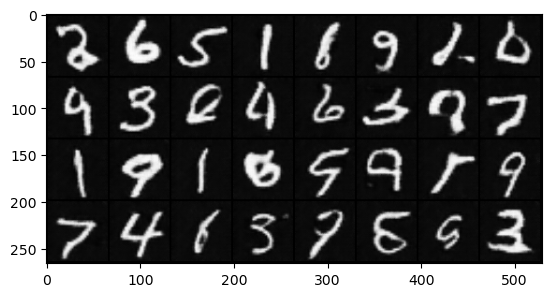

Iteration 0/9: Discriminator Loss: 0.0542, Generator Loss: 6.2787, D(x): 0.9919, D(G(z)) (on fake data): 0.0035, D(G(z)) (on real data): 0.0441
Iteration 500/9: Discriminator Loss: 0.0059, Generator Loss: 5.9002, D(x): 0.9951, D(G(z)) (on fake data): 0.0046, D(G(z)) (on real data): 0.0009
Iteration 1000/9: Discriminator Loss: 1.5574, Generator Loss: 7.5224, D(x): 0.9998, D(G(z)) (on fake data): 0.0009, D(G(z)) (on real data): 0.7207
Iteration 1500/9: Discriminator Loss: 0.0035, Generator Loss: 7.3944, D(x): 0.9983, D(G(z)) (on fake data): 0.0009, D(G(z)) (on real data): 0.0018


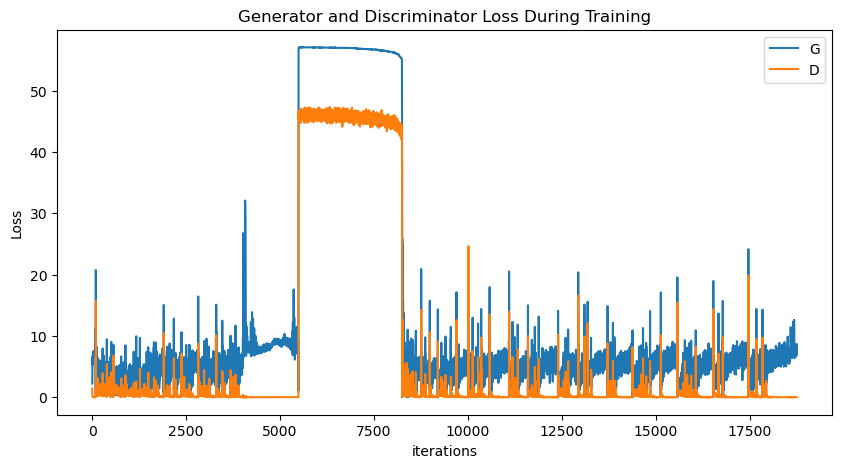

In [3]:
import matplotlib.pyplot as plt

# 存储每个迭代的损失
losses_D = []
losses_G = []

for epoch in range(opt.max_epoch):
    for ii, data in enumerate(dataloader, 0):
        real, _ = data
        input = Variable(real)  # 将真实图像包装为PyTorch变量，用于计算图中
        label = Variable(t.ones(input.size(0)))  # 创建与真实图像数量相同的标签变量，所有值为1，表示真实数据
        noise = t.randn(input.size(0), opt.nz, 1, 1)  # 生成与真实图像数量相同的随机噪声，用于生成假图像
        noise = Variable(noise)  # 将随机噪声包装为PyTorch变量，用于计算图中
        
        if opt.gpu:
            noise = noise.cuda()
            input = input.cuda()
            label = label.cuda()
        
        # ----- train netd -----
        netd.zero_grad()
        ## train netd with real img
        output = netd(input)
        error_real = criterion(output.squeeze(), label)
        error_real.backward()
        D_x = output.data.mean()
        ## train netd with fake img
        fake_pic = netg(noise).detach()
        output2 = netd(fake_pic)
        label.data.fill_(0)  # 0 for fake
        error_fake = criterion(output2.squeeze(), label)
        error_fake.backward()
        D_x2 = output2.data.mean()
        error_D = error_real + error_fake
        optimizerD.step()
        
        # ------ train netg -------
        netg.zero_grad()
        label.data.fill_(1)
        noise.data.normal_(0, 1)
        fake_pic = netg(noise)
        output = netd(fake_pic)
        error_G = criterion(output.squeeze(), label)
        error_G.backward()
        optimizerG.step()
        D_G_z2 = output.data.mean()

        # 存储损失值
        losses_D.append(error_D.item())
        losses_G.append(error_G.item())
        
        if ii % 500 == 0:
            print(f"Iteration {ii}/{epoch}: "
                  f"Discriminator Loss: {error_D.item():.4f}, "
                  f"Generator Loss: {error_G.item():.4f}, "
                  f"D(x): {D_x:.4f}, "
                  f"D(G(z)) (on fake data): {D_G_z2:.4f}, "
                  f"D(G(z)) (on real data): {D_x2:.4f}")
    if epoch % 2 == 0:
        fake_u = netg(fix_noise)
        imgs = make_grid(fake_u.data * 0.5 + 0.5).cpu()  # CHW
        plt.imshow(imgs.permute(1, 2, 0).numpy())  # HWC
        plt.show()

# 绘制损失图像
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_G, label="G")
plt.plot(losses_D, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


## <img src="https://img.icons8.com/?size=100&id=tlQgjxHobhnD&format=png&color=000000" style="height:50px;display:inline">Improved GAN 
---
“Improved Techniques for Training GANs”是一篇由Ian J. Goodfellow 和他的同事在 2016 年发表的论文，这篇论文对生成对抗网络（GANs）的训练过程做出了重要的改进和提议。这些改进主要集中在提高GANs的稳定性和性能上，解决了一些早期GANs训练中的常见问题，例如**模式崩溃（mode collapse）**。

<center><img src="./assets/gan3.png" style="height:200px"></center>

当训练GAN时，理想情况下希望生成器能够学习到数据分布的各个方面，以产生多样性且逼真的数据。然而，模式崩溃指的是生成器开始生成极其有限的样本种类，即便这些样本能够以很高的成功率欺骗判别器。换句话说，生成器找到了一种“捷径”，只生成某些特定的样本（这些样本可能在判别器当前状态下难以被识别为假的），而忽视了数据的其它特征和多样性。这导致生成的数据虽然逼真，但多样性严重不足。

发生模式崩溃的主要原因是GANs模型的不稳定性。例如，如果判别器学习得太快，生成器可能会找到并重复使用能够通过判别器的某些特定模式，而不是学习更多样化的数据生成策略。即，**如果生成器和判别器之间的训练不够平衡，可能会导致一方过于强大，从而促使另一方采取极端策略。**

不稳定性的根源是由于GANs的训练本质上是一个两个网络（生成器和判别器）之间的博弈过程，这个过程可能会非常不稳定。**在理想情况下，两者应该达到纳什均衡，但在实际操作中，往往很难实现**。例如：

- 如果判别器太强，它将过于容易地区分出生成器的输出，导致生成器收到的梯度信号过于强烈和尖锐。这可能使得生成器在训练过程中找不到提升其生成质量的方向，进而陷入困境，无法产生足够逼真的数据。
- 如果判别器太弱，它不能提供足够的准确反馈给生成器。这样生成器即使产生低质量的输出也能“蒙混过关”，使得其没有足够的激励去改进和学习生成更高质量的数据。

想象一个场景，在这个场景中，学生的任务是学习如何绘制非常逼真的风景画来“欺骗”老师，而老师的任务是要分辨出这些画作是学生绘制的，还是由真正的艺术家创作的。如果老师非常有经验（即判别器太强），能够轻易地识别出所有学生的画作，不管他们的质量如何。这会导致以下几个问题：

- 学生（生成器）感到灰心，学生可能会因为自己的作品总是被轻易辨识出来而感到沮丧，逐渐失去改进作品的动力或方向，不知道应该如何进步。其次，缺乏有效反馈，老师可能仅仅告诉学生“这是错误的”，而没有给出具体的改进建议，使得学生难以从中学到如何改进他们的绘画技巧。
- 如果老师的判断能力较弱（即判别器太弱），则会出现学生缺乏挑战，如果老师几乎总是认为学生的作品是真正艺术家的作品，学生可能会觉得自己已经“掌握”了绘画技巧，而实际上他们的作品质量并不高。由于缺乏适当的挑战和准确的反馈，学生可能在自满中停止进步，或不知道自己需要在哪些方面进行提升。

**模式崩溃的解决方法：**

    特征匹配
    小批量判别器
    单侧标签平滑
    虚拟批规范化


**特征匹配（Feature Matching）旨在通过改变生成器（G）的训练目标来提高生成样本的质量和多样性。**

* 在传统的生成对抗网络中，生成器的核心任务是制造出能够欺骗判别器（D）的样本。简单来说，生成器努力创建看起来足够真实，以至于判别器难以区分真伪的图像。
* 然而，这种方法有一个弊端：生成器可能过分专注于那些当前能最容易欺骗判别器的特征，忽视了其它重要特征，导致输出的样本多样性受限。
* 特征匹配技术应运而生，它调整了生成器的目标，使之不再仅仅是欺骗判别器，而是尽可能地缩小生成样本和真实样本在判别器网络的中间层所提取特征的距离。

通过这种方式，特征匹配促使生成器生成在更多维度上与真实数据相似的样本。它不只是追求表面上的逼真度，而是深入到数据的本质特征，从而增加了生成样本的真实性和多样性。这种综合性的训练目标有助于提升生成器的综合性能，避免了过度专注于某些特定特征的陷阱，同时也间接地减少了模式崩溃现象的发生。

In [4]:
# Define a helper class for Feature Matching
class FeatureMatchingLoss(nn.Module):
    def __init__(self, discriminator, layer_idx=-1):
        super(FeatureMatchingLoss, self).__init__()
        self.discriminator = discriminator
        self.layer_idx = layer_idx
        self.criterion = nn.L1Loss()
    
    def forward(self, real_data, fake_data):
        real_features = self.discriminator.forward_features(real_data, layer_idx=self.layer_idx)
        fake_features = self.discriminator.forward_features(fake_data, layer_idx=self.layer_idx)
        return self.criterion(real_features, fake_features)

# Modify the discriminator to extract features from intermediate layers
class DiscriminatorWithFeatures(nn.Module):
    def __init__(self):
        super(DiscriminatorWithFeatures, self).__init__()
        # Define the layers as before
        self.layers = nn.Sequential(
            nn.Conv2d(opt.nc, opt.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.ndf, opt.ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.ndf*2, opt.ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.ndf*4, opt.ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def forward_features(self, x, layer_idx):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == layer_idx:
                break
        return x

# Update the discriminator initialization
netd = DiscriminatorWithFeatures()

# Initialize Feature Matching loss
feature_matching_loss = FeatureMatchingLoss(netd, layer_idx=3)


**小批量判别器（Mini-batch Discrimination）的核心目标是增强模型对样本多样性的关注**

* 这种技术通过在判别器网络中添加一个特殊的层来实现，这个层的功能是评估一个小批次（mini-batch）中各个样本之间的差异性。
* 具体来说，当一个批次的数据输入到判别器中时，这个新增的层会计算并比较批次中各个样本的特征。这些特征包括但不限于样本间的相似度或差异度等统计量。如果生成器开始产生大量相同或相似的样本，这些样本之间的高度相似性就会在这个新层中被明显捕捉到。

由于这种高度的相似性通常不是真实数据集所表现出的特点，因此小批量判别层能够帮助判别器更容易地辨识出这些重复或相似的样本是由生成器生成的，而不是来自真实数据集。这种识别结果将反馈给生成器，使得生成器在后续的训练中受到惩罚，因为它未能产生足够多样化的输出。

因此，小批量判别器实际上是在鼓励生成器创造出更多样化和独特的样本。它通过对样本间相似度的监控，迫使生成器不断探索新的、多样化的生成路径，而不是停留在产生少数几种模式的安全区域。这样，不仅提高了生成样本的质量和多样性，还有效地缓解了模式崩溃的问题，使得生成的图像更加丰富和多变。

In [5]:
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims):
        super(MinibatchDiscrimination, self).__init__()
        self.T = nn.Parameter(t.Tensor(in_features, out_features, kernel_dims))
        nn.init.normal_(self.T, 0, 1)
    
    def forward(self, x):
        M = x.mm(self.T.view(self.T.shape[0], -1))
        M = M.view(-1, self.T.shape[1], self.T.shape[2])
        out = []
        for i in range(M.size(0)):
            out.append(t.sum(t.exp(-t.sum((M[i] - M) ** 2, 2)), 0))
        out = t.cat(out).view(M.size(0), -1)
        return t.cat([x, out], 1)

class DiscriminatorWithMinibatchDiscrimination(nn.Module):
    def __init__(self):
        super(DiscriminatorWithMinibatchDiscrimination, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(opt.nc, opt.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.ndf, opt.ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.ndf*2, opt.ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            MinibatchDiscrimination(opt.ndf*4*4*4, 100, 5), # Minibatch discrimination layer
            nn.Conv2d(opt.ndf*4, opt.ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(opt.ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

netd = DiscriminatorWithMinibatchDiscrimination().cuda()


**单侧标签平滑（One-Sided Label Smoothing）是一种有效的正则化技术**

在传统的GAN训练框架中，判别器的任务是区分真实样本和生成器产生的假样本。为了实现这一目标，真实样本通常被标记为1（代表“真实”），而假样本被标记为0（代表“假”）。然而，这种明确的、二元化的标记方式有时会导致判别器过度自信。
过度自信的判别器意味着它对于其分类的准确性过于确定，这可能会导致两个主要的问题：

* 在面对稍有不同的或未见过的样本时，判别器的性能可能急剧下降，因为它未能学习到足够的泛化能力
- 判别器可能会过度强化生成器的某些特定缺陷，导致生成器在追求欺骗判别器的过程中偏离实际的数据分布，从而可能加剧模式崩溃的风险。

单侧标签平滑正是为了解决这一问题。在这种技术中，**真实样本的标签不再是固定的1，而是被设置为略小于1的值**，例如0.9或0.95。

这样的做法减轻了判别器对每个样本的绝对分类（完全是真或完全是假），从而抑制了其过度自信的倾向。

结果就是一个泛化能力更强的判别器，它对于真实样本的识别不再是完全肯定的，而是给予了一定的容错空间，使得判别器在判断新的或略有差异的真实样本时表现得更为稳健。 

In [6]:
label = Variable(t.ones(input.size(0)) * 0.9)  # Smooth real labels to 0.9


**虚拟批规范化（Virtual Batch Normalization, VBN）是一种改进的规范化技术**

* VBN它在传统批规范化（Batch Normalization, BN）的基础上进行了关键的优化，特别适用于生成对抗网络等复杂模型的训练。BN作为一种广泛应用的技术，通过规范化神经网络中各层的输入，有助于加快训练速度，减少模型对初始化权重的敏感度，并能在一定程度上抑制过拟合。然而，在训练高度复杂的网络时，尤其是GANs中的生成器时，BN面临着一个挑战：**不同批次间的协方差偏移**。

* 协方差偏移是指当网络在不同批次的数据上训练时，即使是同一输入，在网络内部的表示可能会由于每个批次数据的统计属性（如均值、方差）的差异而产生变化。这种变化可能导致网络的训练过程变得不稳定，特别是在GANs中，生成器的输出极易受到输入数据批次差异的影响，从而影响整个网络的学习和生成质量。

* 与传统的BN不同，VBN引入了一个固定的“参考批次”（reference batch）。这个参考批次在训练开始时被选取，并在整个训练过程中保持不变。当进行批规范化时，VBN不仅考虑当前批次的样本统计特性（例如均值和方差），还同时参照这个固定批次的统计特性进行规范化。这种方法有效地减少了由于批次之间的统计属性差异所导致的内部协变量偏移，使得生成器的训练过程更为稳定。

* 通过这种结合当前批次和固定参考批次的统计数据的规范化方法，VBN有助于提高模型在处理不同数据批次时的稳定性和一致性。对于GANs而言，这意味着生成器能够更加平稳地学习和适应，避免因为输入数据的轻微变化而产生较大的输出波动，从而在整个网络训练过程中实现更高的性能和更好的结果。虚拟批规范化因此成为了提高复杂网络稳定性和性能的一个重要工具，尤其在GANs的训练中显示出其独特的价值。



[参考：openai--improved-gan](https://github.com/openai/improved-gan)

## <img src="https://img.icons8.com/?size=100&id=tm3mvGuLwRlx&format=png&color=000000" style="height:50px;display:inline"> f-GAN
---
2016年的论文《f-GAN: Training Generative Neural Samplers using Variational Divergence Minimization》引入了一种新的生成对抗网络（GAN）框架，名为f-GAN。这篇论文通过将传统的GAN训练框架扩展到一系列基于f散度的更广泛的距离或散度措施上，为训练生成模型提供了新的视角和方法。

### GAN模型损失与散度



简单回忆一下GAN模型的目标函数，在标准GAN设置中，生成器的目标是最大化判别器做出错误判断的概率，而判别器的目标是准确区分真实数据和假数据。这可以形式化为以下的极小极大问题:

$$
\min _G \max _D V(D, G)=\mathrm{E}_{x \sim p_{\text {dtas }}(x)}[\log D(x)]+\mathrm{E}_{z \sim p_z(z)}[\log (1-D(G(z)))]
$$

其中, $\mathrm{E}$ 表示期望操作; $p_{\text {data }}$ 是真实数据的分布; $x$ 是从真实数据中抽样的样本; $p_z$ 是生成器的输入噪声分布, 通常假定为高斯或均匀分布; $z$ 是从 $p_z$ 中抽样的噪声向量; $G(z)$ 是生成器 $G$ 使用噪声 $z$ 生成的数据样本。

当判别器 $D$ 和生成器 $G$ 都达到其各自的最优时, GAN 训练过程实际上在最小化生成数据分布 $p_g$ 和真实数据分布 $p_{\text {data }}$ 之间的 Jensen-Shannon 散度（JS 散度）。JS 散度是衡量两个概率分布差异的一种方法, 定义为:
$$
J S(P \| Q)=\frac{1}{2} K L(P \| M)+\frac{1}{2} K L(Q \| M)
$$

其中, $M=\frac{1}{2}(P+Q)$ 是 $P$ 和 $Q$ 的平均分布。 $K L(P \| Q)$ 是两个概率分布 $P$ 和 $Q$ 之间的 Kullback-Leibler 散度, 具体来说 KL 散度定义为:
$$
\mathrm{KL}(P \| Q)=\sum_x P(x) \log \frac{P(x)}{Q(x)}
$$

**下面来仔细推导一下上述结论。**

判别器 $D$ 的目标函数可以表示为:
$$
V(D, G)=\mathrm{E}_{x \sim p_{\text {data }}}[\log D(x)]+\mathrm{E}_{x \sim p_g}[\log (1-D(x))]
$$

我们要找到 $D$ 的形式, 使得 $V(D, G)$ 最大化。为此,可以将期望转换成积分的形式,并分别针对 $p_{\text {data }}$ 和 $p_g$ 进行计算, 公式如下:

$$
V(D, G)=\int_x p_{\text {data }}(x) \log D(x) d x+\int_x p_g(x) \log (1-D(x)) d x
$$

为了最大化 $V(D, G)$, 对 $D$ 求导并令其为 0 , 公式如下:
$$
\frac{\delta V}{\delta D}=\frac{p_{\text {data }}(x)}{D(x)}-\frac{p_g(x)}{1-D(x)}=0
$$

将上述的导数设置为 0 , 求解 $D$ 得到:

$$
\begin{gathered}
\frac{p_{\text {data }}(x)}{D(x)}=\frac{p_g(x)}{1-D(x)} \\
p_{\text {data }}(x)(1-D(x))=p_g(x) D(x) \\
p_{\text {data }}(x)-p_{\text {data }}(x) D(x)=p_g(x) D(x) \\
p_{\text {data }}(x)=D(x)\left(p_{\text {data }}(x)+p_g(x)\right) \\
D(x)=\frac{p_{\text {data }}(x)}{p_{\text {data }}(x)+p_g(x)}
\end{gathered}
$$

**这就是最优判别器 $D^*$ 的形式**。直观地说, 这个形式表示了 $x$ 来自真实数据的概率, 与 $x$来自真实数据和生成数据的总概率之比。当生成器 $G$ 完美地模仿了真实数据分布 $p_{\text {data }}$ 时, 即 $p_g(x)=p_{\text {data }}(x)$ 。此时, $D^*(x)$ 将输出 0.5 , 表示它无法区分真实数据和生成数据, 这也是 GAN 训练的理想状态。

当判别器 $D$ 是最优的, 即 $D^*(x)=\frac{p_{\text {data }}(x)}{p_g(x)+p_{\text {data }}(x)}$ 时, 考虑生成器 $G$ 的最优情况。在这种情况下, 可以重新审视 GAN 的值函数 $V(D, G)$, 它在 $D$ 最优的情况下转化为:

$$
V\left(G, D^*\right)=\mathrm{E}_{x \sim p_{\text {data }}}\left[\log D^*(x)\right]+\mathrm{E}_{x \sim p_s}\left[\log \left(1-D^*(x)\right)\right]
$$

将 $D^*$ 的最优形式代入上述等式中, 可以得到:
$$
V\left(G, D^*\right)=\mathrm{E}_{x \sim p \text { data }}\left[\log \frac{p_{\text {data }}(x)}{p_{\text {data }}(x)+p_g(x)}\right]+\mathrm{E}_{x \sim p_g}\left[\log \frac{p_g(x)}{p_{\text {data }}(x)+p_g(x)}\right]
$$

理论上, 求 $G^*$ 等价于 $p_g(x)$ 可以准确地模仿 $p_{\text {data }}(x)$, 即 $p_g(x)=p_{\text {data }}(x)$, 此时, $\frac{p_{\text {data }}(x)}{p_g(x)+p_{\text {data }}(x)}$ 和 $\frac{p_g(x)}{p_g(x)+p_{\text {data }}(x)}$ 都趋近于 $\frac{1}{2}$ 。

在这种情况下, 由于 $\log \frac{1}{2}=-\log 2$, 当 $p_{\text {data }}=p_g$ 时, 这两个期望值加在一起就是 $-\log 2-\log 2=-2 \log 2$ 。即**最优的生成器将趋向于其最小值 $-2 \log 2$ 。**

**继续推导 GAN 损失函数与散度的关系**。可以对带入最优 $D^*$ 的损失函数进行进一步的推导, 具体如下:

$$
\begin{aligned}
\operatorname{Loss} & =\mathrm{E}_{x \sim p \text { data }}\left[\log \frac{p_{\text {data }}(x)}{p_{\text {data }}(x)+p_g(x)}\right]+\mathrm{E}_{x \sim p_g}\left[\log \frac{p_g(x)}{p_{\text {data }}(x)+p_g(x)}\right] \\
& =\mathrm{E}_{x \sim p \text { data }}\left[\log \left(\frac{1}{2} \cdot \frac{2 p_{\text {data }}(x)}{p_{\text {data }}(x)+p_g(x)}\right)\right]+\mathrm{E}_{x \sim p_g}\left[\log \left(\frac{1}{2} \cdot \frac{2 p_g(x)}{p_{\text {data }}(x)+p_g(x)}\right)\right] \\

& =\mathrm{E}_{x \sim p \mathrm{data}}\left[\log \frac{1}{2}\right]+\mathrm{E}_{x \sim p \mathrm{data}}\left[\log \frac{2 p_{\text {data }}(x)}{p_{\text {data }}(x)+p_g(x)}\right]+\mathrm{E}_{x \sim p_g}\left[\log \frac{1}{2}\right]+\mathrm{E}_{x \sim p_g}\left[\log \frac{2 p_g(x)}{p_{\text {data }}(x)+p_g(x)}\right] \\
& =-\log 4+\mathrm{E}_{x \sim p \text { data }}\left[\log \frac{2 p_{\text {data }}(x)}{p_{\text {data }}(x)+p_g(x)}\right]+\mathrm{E}_{x \sim p_g}\left[\log \frac{2 p_g(x)}{p_{\text {data }}(x)+p_g(x)}\right]
\end{aligned}
$$

下面, 将 $V\left(G, D^*\right)$ 与 KL 和 JS 散度联系起来, 先看 $V\left(G, D^*\right)$ 的后两项。首先, 观察到 $\frac{2 p_{\text {data }}(x)}{p_{\text {data }}(x)+p_g(x)}$ 和 $\frac{2 p_g(x)}{p_{\text {dta }}(x)+p_g(x)}$ 分别是以 $p_{\text {data }}$ 和 $p_{\mathrm{g}}$ 为基础的两个概率分布, 其中每个都与中间分布 $M=\frac{p_{\text {data }}+p_g}{2}$ 有关。这样可以重写 $V\left(G, D^*\right)$ :

$$
\begin{aligned}
V\left(G, D^*\right) & =-\log 4+\mathrm{E}_{x \sim p \text { data }}\left[\log \frac{2 p_{\text {data }}(x)}{p_{\text {data }}(x)+p_g(x)}\right]+\mathrm{E}_{x \sim p_g}\left[\log \frac{2 p_g(x)}{p_{\text {data }}(x)+p_g(x)}\right] \\
& =-\log 4+K L\left(p_{\text {data }} \| \frac{p_{\text {data }}+p_g}{2}\right)+K L\left(p_g \| \frac{p_{\text {data }}+p_g}{2}\right) \\
& =-\log 4+2 \cdot J S\left(p_{\text {data }} \| p_g\right)
\end{aligned}
$$

因此, 可以得出结论: **在最优判别器 $D^*$ 的条件下, GAN 的价值函数 $V\left(G, D^*\right)$ 实际上等于 $-\log 4$ 加上 $p_{\text {data }}$ 和 $p_g$ 之间的两倍 JS 散度**。这表明 GAN 的训练过程本质上是试图最小化$p_{\text {data }}$ 和 $p_g$ 之间的 $\mathrm{JS}$ 散度, 使生成的数据分布尽可能地接近真实数据分布。当 $\mathrm{JS}$ 散度散度最小时, 意味着 $p_{\text {data }}$ 和 $p_g$ 不可区分, 这是 GAN 训练的理想目标。

###  GAN损失的通用框架f-散度

* f-divergence: f-divergence是一类广义的距离度量，用来衡量两个概率分布之间的差异。KL散度、Jensen-Shannon散度、总变差距离等都是f-divergence的特例。f-GAN通过最小化生成分布与真实数据分布之间的f-divergence来训练生成模型。

* 对抗训练: 与传统的GAN类似，f-GAN包含两个网络：生成器（G）和判别器（D）。生成器负责生成假样本，判别器则尝试区分真实样本和假样本。

* 目标函数: f-GAN通过对抗训练来优化f-divergence。具体来说，f-GAN的目标函数可以表示为：

$$
\min _G \max _D V(D, G)=\mathbb{E}_{x \sim p_{\text {data }}}[D(x)]-\mathbb{E}_{z \sim p_z}\left[f^*(D(G(z)))\right]
$$

其中， $f^*$ 是 $\mathrm{f}$-divergence的对偶函数， $p_{\text {data }}$ 是真实数据分布， $p_z$ 是生成器的输入噪声分布。

**f-GAN的特点**

* 灵活性: f-GAN通过选择不同的f-divergence，可以灵活地适应不同的任务需求。例如，通过选择KL散度可以更好地匹配稀疏数据分布，通过选择Jensen-Shannon散度可以提升训练的稳定性。

* 稳定性: 通过优化广义的f-divergence，f-GAN在训练过程中更稳定，避免了传统GAN中常见的模式崩溃和训练不收敛问题。

* 泛化性: f-GAN的框架具备很强的泛化性，能够适用于多种生成任务，包括图像生成、文本生成等。

### <img src="https://img.icons8.com/?size=100&id=fXN7M1okR9HL&format=png&color=000000" style="height:50px;display:inline"> Wasserstein GAN（W-GAN）
---
* WGAN，即Wasserstein GAN，旨在解决传统GAN训练中的一些问题，尤其是训练不稳定和梯度消失。
* WGAN通过使用Wasserstein距离（Earth-Mover距离或EM距离）来衡量真实数据分布和生成数据分布之间的距离，改进了GAN的训练过程。

**从损失角度，传统GAN模型训练不稳定的原因如下**

* 在传统的 GAN 中, 通常使用 $\mathrm{JS}$ 散度或 $\mathrm{KL}$ 散度来衡量真实数据分布 $P_{\text {data }}$ 和生成数据分布 $P_g$ 之间的差异。当两个分布 $P_{\text {data }}$ 和 $P_g$ 没有重叠时, 存在下列问题:

    * 在 KL 散度的情况下, 如果存在任何 $x$ 使得 $P_{\text {data }}(x)>0$ 而 $P_g(x)=0$, 那么 $D_{\mathrm{KL}}\left(P_{\text {data }} \| P_{\mathrm{g}}\right)$ 会变为无穷大。这在数学上是因为 $\log (0)$ 未定义, 并且在训练过程中这通常意味着无法计算梯度。
    * 对于 $\mathrm{JS}$ 散度, 当 $P_{\text {data }}$ 和 $P_g$ 完全不重叠时, $D_{\mathrm{JS}}\left(P_{\text {data }} \| P_g\right)$ 会是一个常数 $(\log 2)$ 。这意味着 GAN 的生成器在这种情况下将无法得到任何指导梯度来调整其参数, 因为不论生成器如何改变, JS 散度都保持不变, 这就是所谓的 “梯度消失” 问题。

* 简单说，当GAN模型的生成器因为初始化等因素导致生成的数据分布与真实数据的分布相差很大时（没有重叠），GAN模型的训练梯度是得不到更新的。

**Wasserstein距离**

Wasserstein距离，也被称为Earth Mover’s Distance（EMD），是一种衡量两个概率分布差异的方法，具体用于度量将一个分布转换成另一个分布所需的“最小工作量”。在理解Wasserstein距离之前，需要首先理解几个关键概念。

* 概率分布：将概率分布想象为一定量的“土堆”，在这个比喻中，每个位置的土堆大小表示概率的值。
* 移动土堆的“工作量”：如果想把一个位置上的土堆移动到另一个位置，那么所需的工作量与土堆的大小和移动距离成正比。

Wasserstein 距离的数学定义是:
$$
W(P, Q)=\inf _{\gamma \in \Pi(P, Q)} \mathrm{E}_{(x, y) \sim \gamma}[\|x-y\|]
$$

其中:
* $P$ 和 $Q$ 是两个概率分布;
* $\Pi(P, Q)$ 表示所有可能的联合分布 $\gamma$, 这些联合分布的边缘分布分别是 $P$ 和 $Q$ 。
* inf 表示求取下确界, 即所有可能方案中的最小值。
* $\mathrm{E}_{(x, y) \sim \gamma}[\|x-y\|]$ 表示在联合分布 $\gamma$ 下，从 $P$ 到 $Q$ 的点对 $(x, y)$ 之间距离的期望值。

从直观上理解，将两个概率分布P和Q想象成两堆形状和体积不同的土堆，Wasserstein距离相当于将一堆土堆的形状完全改变成另一堆土堆所需的最小“工作量”。这里的“工作量”可以理解为土的移动距离和移动的量的乘积之和。所以，即使两个分布完全不重叠（没有共同的支持），Wasserstein距离仍然能给出一个有意义的值，这个值反映了它们之间的“距离”。

从数学上推导: 

* 联合分布 $\gamma$ 代表了从分布 $P$ 到分布 $Q$ 的一个 “转移计划” 。

* 要计算移动总的 “工作量”, 需要计算所有这些移动的 “质量” 乘以其移动的距离 $\|x-y\|$ 。

* 这就是积分 $\int_{X \times X}\|x-y\| d \gamma(x, y)$ 的含义。

* 上述积分在所有可能的 $x$ 和 $y$ 对上进行, 表示整个转移计划的总工作量。由于可能有许多种将 $P$ 转换为 $Q$ 的方式, 需要寻找使得总工作量最小的计划。这就是 $\inf _{\gamma \in \Pi(P, Q)}$ 所表达的含义。**在所有可能的联合分布 $\gamma$ 中寻找一个使得总工作量最小的分布。**

* 在GAN训练中，Wasserstein距离的这种特性使其即使在概率分布不重叠的情况下，也能提供稳定有效的梯度，这解决了传统GAN使用JS散度或KL散度时面临的梯度消失问题。

**WGAN的损失定义**

由于Kantorovich-Rubinstein对偶性，因此可以用另一种方式表达Wasserstein距离：

$$
W\left(\mathrm{P}_{\text {real }}, \mathrm{P}_{\mathrm{gen}}\right)=\sup _{\|f\|_L \leq 1}\left[\mathrm{E}_{x \sim \mathrm{P}_{\text {real }}}[f(x)]-\mathrm{E}_{x \sim \mathrm{P}_{\mathrm{gen}}}[f(x)]\right]
$$

其中 sup 表示上确界, 确保函数 $f$ 遍历所有 1 -利普希茨连续的函数。

关于对偶性推论具体的数学原理在这里不做详细推导, 注意此推论必须要求确保函数 $f$ 遍历所有 1 -利普希茨连续的函数。

1-利普希茨连续函数是一类在数学分析中非常重要的函数, 它们满足特定的 “稳定性”或 “平滑性” 条件。一个函数被称为 1-利普希茨连续, 如果对于其定义域内的任意两点,函数值的差的绝对值不超过这两点间距离的绝对值。形式化地, 一个函数 $f: \mathrm{R}^n \rightarrow \mathrm{R}$ 被称为 1-利普希茨连续, 如果对于所有 $x, y \in \mathrm{R}^n$, 有:$|f(x)-f(y)| \leq\|x-y\|$ 。其中, $\|x-y\|$ 表示 $x$ 和 $y$ 之间的欧几里得距离。1-利普希茨连续性质保证了函数的输出对输入的微小变化只有有限的响应。这意味着函数图形没有剧烈的波动, 表现出一定的平滑性。



**在 WGAN 中, 使用一个神经网络作为判别器 $D$, 它尝试模拟上述对偶性中的最优 1-利普希茨连续函数 $f$ 。** 这就意味着需要训练 $D$ 来最大化 $\mathrm{E}_{x \sim \mathrm{P}_{x=1}}[D(x)]-\mathrm{E}_{x \sim \mathrm{P}_{\mathrm{g} m}}[D(x)]$ 。因此, 判别器 $D$ 的损失函数在 WGAN 中可以表示为:
$$
L_D=-\left(\mathrm{E}_{x \sim \mathrm{P}_{\text {est }}}[D(x)]-\mathrm{E}_{z \sim \mathrm{P}_z}[D(G(z))]\right)
$$

* $\mathrm{E}_{x \sim \mathrm{P}_{\mathrm{Rax}}}[D(x)]$ 是对于真实数据样本 $x$ 的判别器输出的期望值
* $\mathrm{E}_{z \sim P_Z}[D(G(z))]$ 是对于生成器 $G$ 生成的假数据样本的判别器输出的期望值。

* 对于生成器 $G L_G=-\mathrm{E}_{z \sim \mathcal{E}}[D(G(z))]$, 生成器 $G$ 的目标是最大化判别器 $D$ 对其生成的假样本的评分。

为了确保计算出的Wasserstein距离有效，WGAN要求判别器是一个1-利普希茨函数。

* 在WGAN的初始版本中，通常通过剪裁评价器的权重到一个固定范围（例如[−0.01,0.01]）来实现。

* 在后续的研究中，利用梯度惩罚来代替权重剪裁，以便更有效地实施1-利普希茨约束并提高训练稳定性。

梯度惩罚的基本思想是直接约束判别器的梯度, 而不是通过剪裁其权重。这样做的原理是基于 1-利普希茨函数的一个特性：对于 1-利普希茨函数 $f$, 在其定义域中的任意一点 $x$,其梯度的范数不会超过 1 , 即 $\|\nabla f(x)\| \leq 1$ 。

在WGAN-GP（Wasserstein GAN with Gradient Penalty）中，为了强制实现这一约束，研究者们提出了在判别器的损失函数中加入一个梯度惩罚项。这个惩罚项基于随机采样的点上判别器梯度的二范数，目的是使这个梯度的二范数尽可能地接近1。

具体来说, WGAN-GP 中判别器的损失函数 $L_D$ 被修改为包含以下梯度惩罚项:
$$
L_D=\underbrace{\mathrm{E}_{\hat{x} \sim \mathrm{P}_{\mathrm{g}}}[D(\tilde{x})]-\mathrm{E}_{x \sim \mathrm{P}}[D(x)]}_{\text {原WGAN判别㗊损失 }}+\lambda \underbrace{\left.\mathrm{E}_{\hat{x} \sim \mathrm{P}_{\hat{x}}}\left[\left\|\nabla_{\hat{x}} D(\hat{x})\right\|_2-1\right)^2\right]}_{\text {梯度歪罚项 }}
$$
其中:
* $\mathrm{P}_r$ 是真实数据分布;
* $\mathrm{P}_g$ 是生成器的数据分布;
* $\hat{x}$ 是从真实数据和生成数据之间的插值（例如, $\hat{x}=\epsilon x+(1-\epsilon) \tilde{x}$, 其中 $\epsilon$ 是一个随机数, 通常在 0 到 1 之间均匀采样）;
* $\lambda$ 是梯度惩罚的权重, 是一个超参数, 需要根据具体应用进行调整。

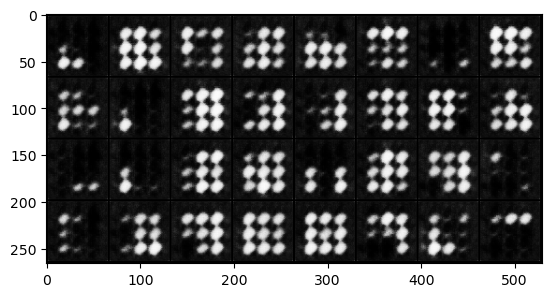

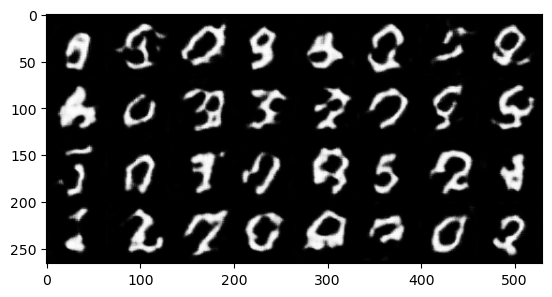

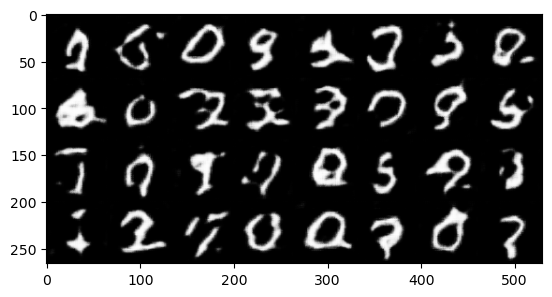

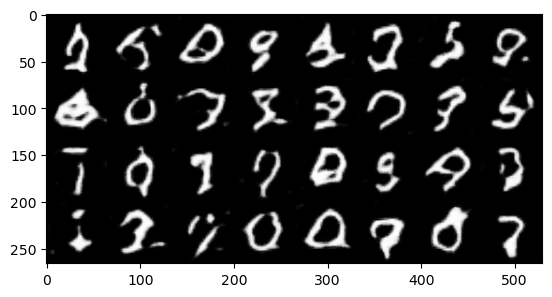

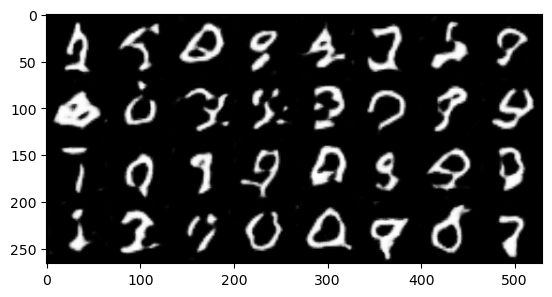

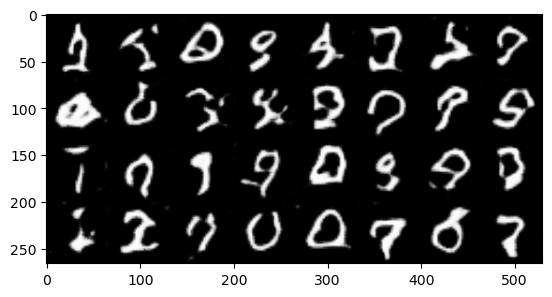

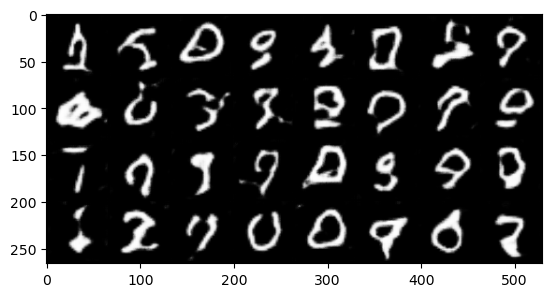

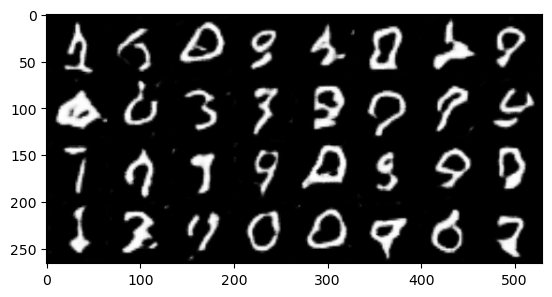

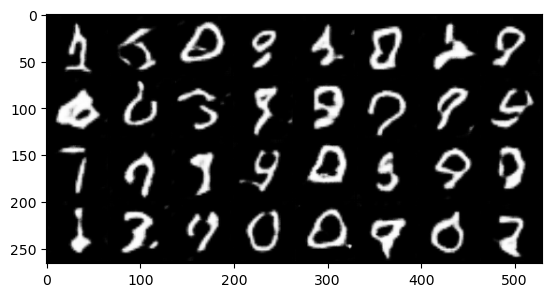

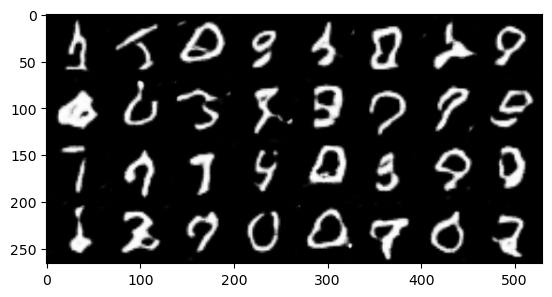

In [7]:
import torch as t
from torch import nn
from torch.autograd import Variable
from torch.optim import RMSprop
from torchvision.utils import make_grid
from pylab import plt
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
class Config:
    lr = 0.00005
    nz = 100 # noise dimension
    image_size = 64
    image_size2 = 64
    nc = 1 # chanel of img 
    ngf = 64 # generate channel
    ndf = 64 # discriminative channel
    beta1 = 0.5
    batch_size = 32
    max_epoch = 40 # =1 when debug
    workers = 2
    gpu = True # use gpu or not
    clamp_num=0.01# WGAN clip gradient
    
opt=Config()

netg = nn.Sequential(
            nn.ConvTranspose2d(opt.nz,opt.ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(opt.ngf*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*8,opt.ngf*4,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*4,opt.ngf*2,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*2,opt.ngf,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf,opt.nc,4,2,1,bias=False),
            nn.Tanh()
        )

netd = nn.Sequential(
            nn.Conv2d(opt.nc,opt.ndf,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf,opt.ndf*2,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*2),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*2,opt.ndf*4,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*4),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*4,opt.ndf*8,4,2,1,bias=False),
            nn.BatchNorm2d(opt.ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(opt.ndf*8,1,4,1,0,bias=False),
            # Modification 1: remove sigmoid
            # nn.Sigmoid()
        )
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
#     else:print(class_name)

netd.apply(weight_init)
netg.apply(weight_init)

# modification 2: Use RMSprop instead of Adam
# optimizer
optimizerD = RMSprop(netd.parameters(),lr=opt.lr ) 
optimizerG = RMSprop(netg.parameters(),lr=opt.lr )  

# modification3: No Log in loss
# criterion
# criterion = nn.BCELoss()

fix_noise = Variable(t.FloatTensor(opt.batch_size,opt.nz,1,1).normal_(0,1))
if opt.gpu:
    fix_noise = fix_noise.cuda()
    netd.cuda()
    netg.cuda()

# begin training
one=t.FloatTensor([1])
mone=-1*one

for epoch in range(opt.max_epoch):
    for ii, data in enumerate(dataloader, 0):
        real, _ = data
        input = Variable(real)
        noise = t.randn(input.size(0), opt.nz, 1, 1)
        noise = Variable(noise)
        
        if opt.gpu:
            one = one.cuda()
            mone = mone.cuda()
            noise = noise.cuda()
            input = input.cuda()

        # 裁剪判别器参数
        for parm in netd.parameters():
            parm.data.clamp_(-opt.clamp_num, opt.clamp_num)
        
        # 训练判别器
        netd.zero_grad()
        ## 使用真实图片训练判别器
        output = netd(input)
        output.backward(one.expand_as(output))  # 修改点：对于真实样本，梯度为正，即增加判别器输出的值。
        ## 使用生成的假图片训练判别器
        fake_pic = netg(noise).detach()
        output2 = netd(fake_pic)
        output2.backward(mone.expand_as(output2))  # 修改点：使梯度张量形状匹配
        optimizerD.step()
        
        # 训练生成器
        if (ii + 1) % 5 == 0:
            netg.zero_grad()
            noise.data.normal_(0, 1)
            fake_pic = netg(noise)
            output = netd(fake_pic)
            output.backward(one.expand_as(output))  # 修改点：对于生成样本，梯度为负，即减少判别器输出的值。
            optimizerG.step()

    if epoch % 4 ==0:            
        fake_u = netg(fix_noise)
        imgs = make_grid(fake_u.data * 0.5 + 0.5).cpu()  # CHW
        plt.imshow(imgs.permute(1, 2, 0).numpy())  # HWC
        plt.show()


## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* <a href="https://d2l.ai/chapter_recurrent-neural-networks/index.html">Dive Into Deep Learning - Recurrent Neural Networks</a>
* <a href="https://atcold.github.io/pytorch-Deep-Learning/en/week12/12-1/">DS-GA 1008 - NYU CENTER FOR DATA SCIENCE - Deep Sequence Modeling</a>
* <a href="https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html">Text classification with the torchtext library
</a>
* <a href="https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/">Tricks For Training Transformers - Borealis AI - P. Xu, S. Prince</a>
* <a href="https://taldatech.github.io">Tal Daniel</a>